<a href="https://colab.research.google.com/github/sharclark/Project1_Dojo/blob/main/Outlet_Sales_Prediction_Model_Shar_Clark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display='diagram')

In [3]:
path = '/content/sales_predictions (2).csv'
df = pd.read_csv(path)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
df.duplicated().sum()


0

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   int64  
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   int64  
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                8523 non-null   int64  
 7   Outlet_Location_Type       8523 non-null   int64  
 8   Outlet_Type                8523 non-null   int64  
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(6)
memory usage: 666.0 KB


In [6]:
df.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [7]:
#dropping unecessary columns
df = df.drop(columns=['Item_Identifier', 'Outlet_Identifier',])

In [8]:
# can fix categorical data before splitting
df.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Establishment_Year', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [10]:
#which columns are categorical?
dtypes = df.dtypes
str_cols = dtypes[dtypes=='object'].index
str_cols

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [11]:
for col in str_cols:
    print(f"- Column= {col}")
    print(df[col].value_counts(dropna=False))
    print('\n\n')


- Column= Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64



- Column= Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64



- Column= Outlet_Size
Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64



- Column= Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64



- Column= Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermark

In [12]:
df['Item_Fat_Content'].replace({'LF':'Low Fat', 'low fat': 'Low Fat', 'reg':'Regular'}, inplace=True)
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [14]:
#going to create a new column for outlet size for missing values and just call it missing. too much data to impute
# this will need to be OHE

df['Outlet_Size'].fillna('Missing', inplace=True)
df['Outlet_Size'].value_counts()

# other categorical columns look good

Medium     2793
Missing    2410
Small      2388
High        932
Name: Outlet_Size, dtype: int64

In [15]:
#ordinal encode those before split 

repdic_fatcont = {'Low Fat':1, 'Regular':2}
df['Item_Fat_Content'].replace(repdic_fatcont, inplace=True)
df['Item_Fat_Content']

0       1
1       2
2       1
3       2
4       1
       ..
8518    1
8519    2
8520    1
8521    2
8522    1
Name: Item_Fat_Content, Length: 8523, dtype: int64

In [16]:
repdic_type = {'Fruits and Vegetables': 0, 'Snack Foods': 2, 'Household' :3, 'Frozen Foods':4, 'Dairy': 5, 'Canned':6 , 'Baking Goods':7, 'Health and Hygiene':8, 'Soft Drinks':9, 'Meat':10, 'Breads':11, 'Hard Drinks':12, 'Others':13, 'Starchy Foods':14, 'Breakfast': 15, 'Seafood':16 }
df['Item_Type'].replace(repdic_type,inplace=True)
df['Item_Type']

0        5
1        9
2       10
3        0
4        3
        ..
8518     2
8519     7
8520     8
8521     2
8522     9
Name: Item_Type, Length: 8523, dtype: int64

In [17]:
repoutletdic = {'Missing':0, 'Small':1, 'Medium':2, 'High':3}
df['Outlet_Size'].replace(repoutletdic, inplace=True)
df['Outlet_Size']

0       2
1       2
2       2
3       0
4       3
       ..
8518    3
8519    0
8520    1
8521    2
8522    1
Name: Outlet_Size, Length: 8523, dtype: int64

In [18]:
rep_loctype = {'Tier 1': 1, 'Tier 2': 2, 'Tier 3':3}
df['Outlet_Location_Type'].replace(rep_loctype, inplace=True)
df['Outlet_Location_Type']

0       1
1       3
2       1
3       3
4       3
       ..
8518    3
8519    2
8520    2
8521    3
8522    1
Name: Outlet_Location_Type, Length: 8523, dtype: int64

In [19]:
rep_outtype = {'Grocery Store':0, 'Supermarket Type1': 1, 'Supermarket Type2': 2, 'Supermarket Type3': 3}
df['Outlet_Type'].replace(rep_outtype, inplace=True)
df['Outlet_Type']

0       1
1       2
2       1
3       0
4       1
       ..
8518    1
8519    1
8520    1
8521    2
8522    1
Name: Outlet_Type, Length: 8523, dtype: int64

In [20]:
for col in str_cols:
    print(f"- Column= {col}")
    print(df[col].value_counts(dropna=False))
    print('\n\n')

- Column= Item_Fat_Content
1    5517
2    3006
Name: Item_Fat_Content, dtype: int64



- Column= Item_Type
0     1232
2     1200
3      910
4      856
5      682
6      649
7      648
8      520
9      445
10     425
11     251
12     214
13     169
14     148
15     110
16      64
Name: Item_Type, dtype: int64



- Column= Outlet_Size
2    2793
0    2410
1    2388
3     932
Name: Outlet_Size, dtype: int64



- Column= Outlet_Location_Type
3    3350
2    2785
1    2388
Name: Outlet_Location_Type, dtype: int64



- Column= Outlet_Type
1    5577
0    1083
3     935
2     928
Name: Outlet_Type, dtype: int64





In [22]:
df.info()
#item weight is the only one with missing data since i created a new column with the ordinal one earlier. can use mean imputer for this
#impute afer split so there is no data leakage

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   int64  
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   int64  
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                8523 non-null   int64  
 7   Outlet_Location_Type       8523 non-null   int64  
 8   Outlet_Type                8523 non-null   int64  
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(6)
memory usage: 666.0 KB


In [23]:
#split
X = df.drop('Item_Outlet_Sales', axis=1)
y = df['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [24]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [25]:
# Imputer
mean_imputer = SimpleImputer(strategy='mean')

# Scaler
scaler = StandardScaler()

# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [26]:
# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [28]:
categorical_pipe = make_pipeline(mean_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [29]:
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

In [30]:
preprocessor = make_column_transformer(number_tuple, category_tuple, remainder = 'passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f512a5e2ca0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f5129a90af0>)])

In [31]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f512a5e2ca0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f5129a90af0>)])

In [32]:
# transform train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [50]:
preprocessor.fit(X_train)

# Check for missing values and that data is scaled and one-hot encoded
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 9)




array([[ 0.81724868, -0.7403206 , -0.71277507, ...,  0.74812466,
         1.08494779,  0.98357205],
       [ 0.5563395 ,  1.35076614, -1.29105225, ...,  0.74812466,
         1.08494779,  0.98357205],
       [-0.13151196,  1.35076614,  1.81331864, ...,  0.74812466,
        -1.38477667, -0.26359965],
       ...,
       [ 1.11373638, -0.7403206 , -0.92052713, ..., -1.2768649 ,
        -0.14991444, -0.26359965],
       [ 1.76600931, -0.7403206 , -0.2277552 , ..., -1.2768649 ,
        -0.14991444, -0.26359965],
       [ 0.81724868, -0.7403206 , -0.95867683, ..., -0.26437012,
        -1.38477667, -0.26359965]])

In [58]:
#Linear Regression Model
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

#modeling pipeline
reg_pipe = make_pipeline(preprocessor, reg)

# fit the model
reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f512a5e2ca0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5129a90af0>)])),
                ('linearregression', LinearRegression())])

In [59]:
predictions = reg_pipe.predict(X_test)
predictions

array([ 908.65822632,  708.82963128,  831.91464237, ..., 2944.23862833,
       2004.58146817, 2150.15298209])

In [60]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def model_metrics(pipe, x_train, y_train, x_test, y_test, 
                       model_name='Regression Model', ):
  ## Train
  mae = mean_absolute_error(y_train, pipe.predict(x_train))
  mse = mean_squared_error(y_train, pipe.predict(x_train))
  rmse = np.sqrt(mean_squared_error(y_train, pipe.predict(x_train)))
  r2 = r2_score(y_train, pipe.predict(x_train))
  print(f'{model_name} Train Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

  ## Test
  mae = mean_absolute_error(y_test, pipe.predict(x_test))
  mse = mean_squared_error(y_test, pipe.predict(x_test))
  rmse = np.sqrt(mean_squared_error(y_test, pipe.predict(x_test)))
  r2 = r2_score(y_test, pipe.predict(x_test))

  # Display the metrics for the model
  print(f'{model_name} Test Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

In [62]:
model_metrics(reg_pipe, X_train, y_train, X_test, y_test, model_name='Linear Regression')

Linear Regression Train Scores
MAE: 917.9871 
MSE: 1,485,004.0542 
RMSE: 1,218.6074 
R2: 0.4982

Linear Regression Test Scores
MAE: 872.6103 
MSE: 1,370,832.4401 
RMSE: 1,170.8255 
R2: 0.5031



Based on the R2 score, the Linear Regression model can account for half of the errors of this model. The RMSE score tells us that we can predict sales with an average error of around $1,100. That seems like a high likelyhood of error. 

In [65]:
# Regression Tree
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
dec_tree_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f512a5e2ca0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5129a90af0>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [74]:
# evaluate the model
train_score = dec_tree.score(X_train_processed, y_train)
test_score = dec_tree.score(X_test_processed, y_test)
print(train_score)
print(test_score)
# model is definitely overfitting

1.0
0.21242472196056372


In [77]:
# List of values to try for max_depth:
depths = list(range(2, 36)) # will try every value between 2 and 36
# Data frame to store the score for each value of max_depth:
scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dec_tree.fit(X_train_processed, y_train)
    train_score = dec_tree.score(X_train_processed, y_train)
    test_score = dec_tree.score(X_test_processed, y_test)
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score


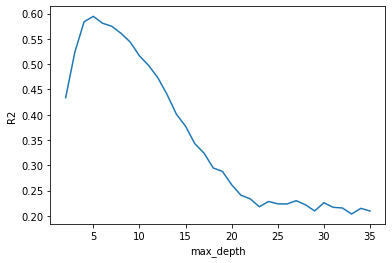

In [78]:
# Visualize which max_depth leads to the highest r2 score
import matplotlib.pyplot as plt
plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');


In [80]:
# Let's run the model with our optimized value for max_depth
dec_tree_5 = DecisionTreeRegressor(max_depth = 5, random_state = 42)
dec_tree_5.fit(X_train_processed, y_train)
train_5_score = dec_tree_5.score(X_train_processed, y_train)
test_5_score = dec_tree_5.score(X_test_processed, y_test)
print(train_5_score)
print(test_5_score)


0.6039395395685383
0.5947031157793665


In [82]:
model_metrics(dec_tree_5, x_train=X_train_processed, y_train=y_train, 
                          x_test=X_test_processed, y_test=y_test, 
                           model_name='Decision Tree Model')

Decision Tree Model Train Scores
MAE: 762.6251 
MSE: 1,172,123.3890 
RMSE: 1,082.6465 
R2: 0.6039

Decision Tree Model Test Scores
MAE: 738.4420 
MSE: 1,118,204.8984 
RMSE: 1,057.4521 
R2: 0.5947



After tuning this model, the R2 score is higher than before. This model accounts for 60% of the errors in the and is no longer overfitted. The RMSE notes that we can predict sales by about $1000. 

In [83]:
model_metrics(dec_tree_5, x_train=X_train_processed, y_train=y_train, 
                          x_test=X_test_processed, y_test=y_test, 
                           model_name='Decision Tree Model')

model_metrics(reg_pipe, X_train, y_train, X_test, y_test, model_name='Linear Regression')

Decision Tree Model Train Scores
MAE: 762.6251 
MSE: 1,172,123.3890 
RMSE: 1,082.6465 
R2: 0.6039

Decision Tree Model Test Scores
MAE: 738.4420 
MSE: 1,118,204.8984 
RMSE: 1,057.4521 
R2: 0.5947

Linear Regression Train Scores
MAE: 917.9871 
MSE: 1,485,004.0542 
RMSE: 1,218.6074 
R2: 0.4982

Linear Regression Test Scores
MAE: 872.6103 
MSE: 1,370,832.4401 
RMSE: 1,170.8255 
R2: 0.5031



I would reccomend using the Decision Tree Model, when compared to the Linear Regression Model. The RMSE is lower for the Decision Tree Model and the r2 is higher. 